In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import folium
from folium import plugins
import datetime as dt
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter, YearLocator
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_file, show
from bokeh.models import Range1d

%matplotlib inline 
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)

In [2]:
MESI = ['gen','feb','mar','apr','mag','giu','lug','ago','set','ott','nov','dic']

# Import data

In [3]:
df = pd.read_csv('data/incidenti_2007_2017.csv')

In [4]:
df = df[df['DataOraIncidente_year']!=2017].copy()

In [5]:
df.head()

,Chilometrica,CondizioneAtmosferica,Confermato,DaSpecificare,DataOraIncidente,FondoStradale,Gruppo,ID,Illuminazione,Latitudine,Localizzazione1,Localizzazione2,Longitudine,NUM_FERITI,NUM_ILLESI,NUM_MORTI,NUM_RISERVATA,NaturaIncidente,ParticolaritaStrade,Pavimentazione,Segnaletica,Strada02,Strada1,Strada2,TipoStrada,Traffico,Visibilita,DataOraIncidente_date,DataOraIncidente_time,DataOraIncidente_time_h,DataOraIncidente_weekday,DataOraIncidente_month,DataOraIncidente_year
0,151-153,Nuvoloso,1.0,NaN,2007-01-01 00:00:00,Asciutto,18,1707637,Sufficiente,NaN,Strada Urbana,in prossimità,NaN,0,0,0,0,Veicolo in marcia contro veicolo in sosta,Rettilineo,Asfaltata,Verticale ed orizzontale,del civico n.,VIA ANASTASIO II,NaN,Due carreggiate,Normale,Buona,2007-01-01,00:00:00,0,0,1,2007
1,537,Nuvoloso,1.0,NaN,2007-01-01 00:40:00,Asciutto,4,1708657,Sufficiente,NaN,Provinciale entro l'abitato,in prossimità,NaN,2,9,0,0,Tamponamento Multiplo,Rettilineo,Asfaltata,Verticale ed orizzontale,del civico n.,VIA NOMENTANA,NaN,Più di due carreggiate,Normale,Buona,2007-01-01,00:40:00,0,0,1,2007
2,123/A,Pioggia in atto,1.0,NaN,2007-01-01 01:10:00,Bagnato (pioggia),18,1707214,Sufficiente,NaN,Strada Urbana,in prossimità,NaN,1,2,0,0,Scontro frontale/laterale DX fra veicoli in ma...,Rettilineo,Asfaltata,Orizzontale,del civico n.,VIA MATTIA BATTISTINI,NaN,Una carreggiata a doppio senso,Normale,Buona,2007-01-01,01:10:00,1,0,1,2007
3,13,Nebbia,0.0,NaN,2007-01-01 01:30:00,Bagnato (umidità in atto),5,1707689,Sufficiente,NaN,Strada Urbana,in prossimità,NaN,0,1,0,0,Veicolo in marcia contro veicoli fermi,Rettilineo,Asfaltata,Verticale,del civico n.,VIA CESARE DE LOLLIS,NaN,Una carreggiata a senso unico di marcia,Normale,Sufficiente,2007-01-01,01:30:00,1,0,1,2007
4,NaN,Nuvoloso,1.0,NaN,2007-01-01 01:30:00,Asciutto,16,1708159,Sufficiente,NaN,Strada Urbana,all'intersezione con,NaN,0,2,0,0,Scontro frontale/laterale SX fra veicoli in ma...,Incrocio,In cubetti di porfido,Verticale ed orizzontale,VIA RAFFAELLO GIOVAGNOLI,VIALE DEI QUATTRO VENTI,VIA RAFFAELLO GIOVAGNOLI,Una carreggiata a doppio senso,Normale,Buona,2007-01-01,01:30:00,1,0,1,2007


In [6]:
len(df)

344040

In [7]:
df['DataOraIncidente'] = df['DataOraIncidente'].apply(lambda d: pd.to_datetime(d))

#  
#  
# Strade

In [8]:
df.groupby('Strada1').count()[['ID']].sort_values(by='ID', ascending=False).head(10)

,ID
Strada1,
VIA CRISTOFORO COLOMBO,7039
VIA CASILINA,6709
VIA PRENESTINA,5849
VIA TIBURTINA,5630
VIA TUSCOLANA,4766
VIA NOMENTANA,4022
VIALE PALMIRO TOGLIATTI,3722
VIA CASSIA,3428
VIA DI BOCCEA,3410


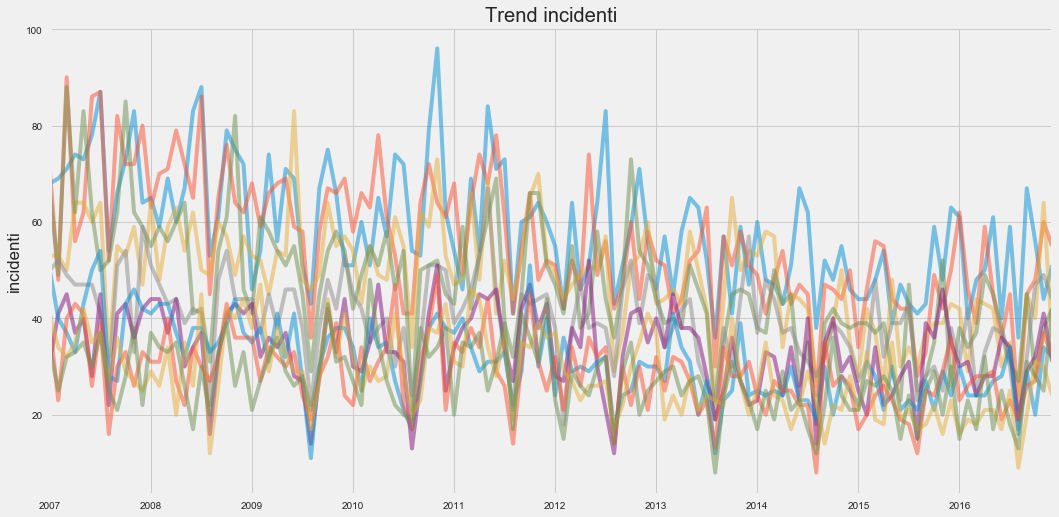

In [9]:
top_strade = df.groupby('Strada1')\
               .count()[['ID']]\
               .sort_values(by='ID', ascending=False)\
               .head(10).index.values

for i,strada in enumerate(top_strade):
    if i==0:
        ax = df[df['Strada1']==strada].groupby('DataOraIncidente')\
                              .count()[['ID']]\
                              .resample('1M')\
                              .sum()\
                              .plot(figsize=(16,8),alpha=0.5)
    else:
        df[df['Strada1']==strada].groupby('DataOraIncidente')\
                              .count()[['ID']]\
                              .resample('1M')\
                              .sum()\
                              .plot(ax=ax,alpha=0.5)
    
                    
plt.title('Trend incidenti')
plt.legend().set_visible(False)
plt.xticks(rotation=0)
plt.ylabel('incidenti')
plt.xlabel('')
#plt.ylim(10,100)
plt.show()

### Bokeh

In [67]:
p = figure(plot_width=1000, plot_height=500, x_axis_type="datetime")
p.title.text = 'Le 10 strade con piu incidenti '+\
               '(le strade possono essere rimosse cliccando sulla legenda)'

cmap = get_cmap(10)
for i,strada in enumerate(top_strade):
    df_strada = df[df['Strada1']==strada].groupby('DataOraIncidente')\
                                         .count()[['ID']]\
                                         .resample('1M')\
                                         .sum()
    p.line(df_strada.index, 
           df_strada['ID'], 
           line_width=2, 
           color=matplotlib.colors.to_hex(np.random.rand(3,)), 
           alpha=1, 
           legend=strada)
p.legend.location = "top_left"
p.legend.click_policy="hide"
p.x_range = Range1d(pd.to_datetime('01/01/2004'),pd.to_datetime('01/01/2017'))
output_file("strade_interactive_plot.html", title="interactive_legend.py example")
show(p)

# Strade: incidenti vs incidenti mortali

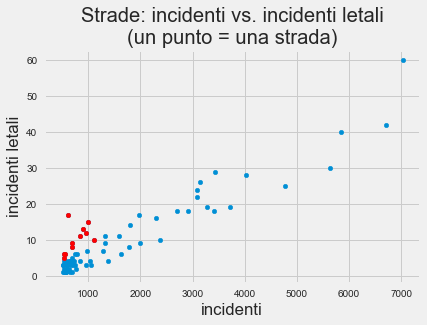

In [76]:
df_temp = pd.merge(df.groupby('Strada1').count()[['ID']].rename(columns={'ID':'inc'}),
                   df[df['NUM_MORTI']>0].groupby('Strada1').count()[['ID']].rename(columns={'ID':'let_inc'}),
                   left_index=True,
                   right_index=True).reset_index()
df_temp['let_inc_%'] = 100*df_temp['let_inc'] / df_temp['inc']
df_temp = df_temp[df_temp['inc']>500]

plt.scatter(df_temp['inc'],
            df_temp['let_inc'],
            s=20)

threshold = 0.9
plt.scatter(df_temp[df_temp['let_inc_%']>threshold]['inc'],
            df_temp[df_temp['let_inc_%']>threshold]['let_inc'],
            color='red',
            s=20)
# for x,y,strada in df_temp[df_temp['let_inc_%']>threshold][['inc','let_inc','Strada1']].values:
#     plt.text(x,y,strada, fontsize=15)

plt.title('Strade: incidenti vs. incidenti letali\n(un punto = una strada)')
plt.legend().set_visible(False)
#plt.xticks(rotation=0)
plt.xlabel('incidenti')
plt.ylabel('incidenti letali')
#plt.ylim(10,100)
plt.show()

AA


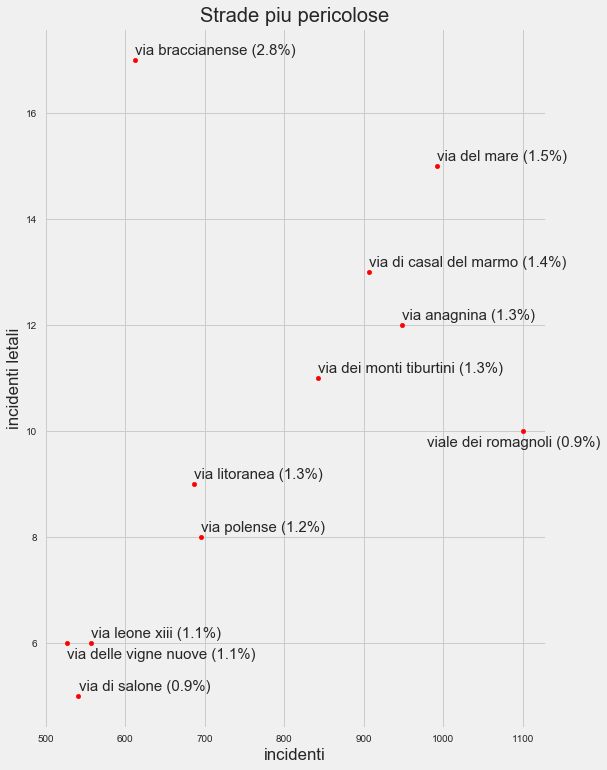

In [102]:
plt.figure(figsize=(8,12))
df_temp = pd.merge(df.groupby('Strada1').count()[['ID']].rename(columns={'ID':'inc'}),
                   df[df['NUM_MORTI']>0].groupby('Strada1').count()[['ID']].rename(columns={'ID':'let_inc'}),
                   left_index=True,
                   right_index=True).reset_index()
df_temp['let_inc_%'] = 100*df_temp['let_inc'] / df_temp['inc']
df_temp = df_temp[df_temp['inc']>500]

threshold = 0.9
plt.scatter(df_temp[df_temp['let_inc_%']>threshold]['inc'],
            df_temp[df_temp['let_inc_%']>threshold]['let_inc'],
            color='red',
            s=20)
for x,y,strada in df_temp[df_temp['let_inc_%']>threshold][['inc','let_inc','Strada1']].values:
    text = '{} ({:1.1f}%)'.format(strada.lower(),100*y/x)
    if strada=='VIA DELLE VIGNE NUOVE':
        plt.text(x-0.3,y-0.3,text, fontsize=15)
    elif strada=='VIALE DEI ROMAGNOLI':
        print('AA')
        plt.text(x-120,y-0.3, text, fontsize=15)
    else:
        plt.text(x+0.3,y+0.1,text, fontsize=15)
    
plt.title('Strade piu pericolose')
plt.legend().set_visible(False)
#plt.xticks(rotation=0)
plt.xlabel('incidenti')
plt.ylabel('incidenti letali')
#plt.ylim(10,100)
plt.show()

In [ ]:
# g = sns.jointplot("inc", "let_inc", 
#                   data=df_temp, 
#                   kind="reg",
#                   #color="b", 
#                   size=7)

In [ ]:
# df_temp.sort_values(by='let_inc_%',ascending=False).head(20)[['let_inc_%']].plot(kind='barh')

In [ ]:
# df_temp.sort_values(by='let_inc_%',ascending=False).head(20)

#  
#  
# Natura incidente

In [ ]:
# df.groupby('NaturaIncidente')\
#   .count()[['ID']]\
#   .sort_values(by='ID', ascending=True)\
#   .plot(kind='barh')

In [103]:
opzioni_scontro = ['Scontro laterale fra veicoli in marcia',
                   'Scontro frontale/laterale SX fra veicoli in marcia',
                   'Scontro frontale/laterale DX fra veicoli in marcia',
                   'Scontro frontale fra veicoli in marcia',
                   'Scontro frontale fra veicoli in marcia ']
df['NaturaIncidente'] = df['NaturaIncidente'].apply(lambda x: 'Scontro frontale/laterale fra veicoli in marcia' if x in opzioni_scontro else x)                    

opzioni_scontro = ['Veicolo in marcia contro veicolo arresto',
                    'Veicolo in marcia contro veicoli fermi',
                    'Veicoli in marcia contro veicolo fermo',
                    'Veicolo in marcia contro veicoli in arresto',
                    'Veicoli in marcia contro veicoli fermi',
                    'Veicolo in marcia contro veicolo fermo',
                    'Veicolo in marcia contro veicoli in sosta']
df['NaturaIncidente'] = df['NaturaIncidente'].apply(lambda x: 'Veicolo/i in marcia contro veicolo/i fermo/i' if x in opzioni_scontro else x)                    

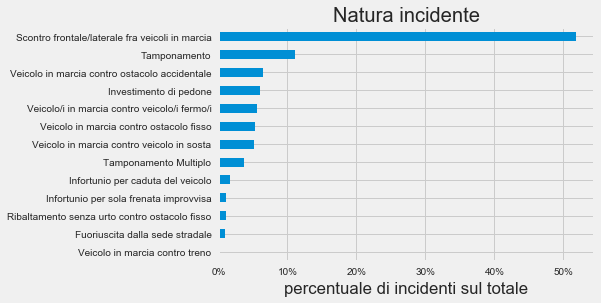

In [117]:
df.groupby('NaturaIncidente')\
  .count()[['ID']]\
  .apply(lambda x: 100*x/len(df))\
  .sort_values(by='ID', ascending=True)\
  .plot(kind='barh')

plt.title('Natura incidente')
plt.xlabel('percentuale di incidenti sul totale')
plt.ylabel('')
plt.xticks(range(0,60,10),['{}%'.format(x) for x in range(0,60,10)])
plt.legend().set_visible(False)
plt.show()

#  
#  
# Illuminazione

In [ ]:
# df_temp = df[['Illuminazione','NUM_MORTI']].copy()
# df_temp['NUM_MORTI'] = df_temp['NUM_MORTI'].apply(lambda x: 1 if x>0 else 0)
# df_temp.groupby(['Illuminazione']).sum()[['NUM_MORTI']]

In [118]:
df_temp = pd.merge(df.groupby(['Illuminazione']).count()[['ID']].rename(columns={'ID':'incidenti'}),
                   df.groupby(['Illuminazione']).sum()[['NUM_MORTI']].rename(columns={'NUM_MORTI':'incidenti_mortali'}),
                   left_index=True,
                   right_index=True)

In [119]:
df_temp['incidenti_mortali_%'] = np.round(100 * df_temp['incidenti_mortali'] / df_temp['incidenti'], 2)
df_temp

,incidenti,incidenti_mortali,incidenti_mortali_%
Illuminazione,,,
Inesistente,4774,95,1.99
Insufficiente,4679,74,1.58
Ore Diurne,245021,843,0.34
Sufficiente,88302,577,0.65


In [120]:
from scipy.stats import chisquare 

expected = np.array([88302/(88302+551), 551/(88302+551)])

observed = np.array([4774/(4774+91), 91/(4774+91)])
print(chisquare(observed, expected))

observed = np.array([4679/(4679+70), 70/(4679+70)])
print(chisquare(observed, expected))

Power_divergenceResult(statistic=0.02536908793740323, pvalue=0.87345082573143273)
Power_divergenceResult(statistic=0.011830543527904939, pvalue=0.91338626592844374)


In [181]:
df_temp.reset_index()

,Illuminazione,incidenti,incidenti_mortali,incidenti_mortali_%
0,Inesistente,4774,95,1.99
1,Insufficiente,4679,74,1.58
2,Ore Diurne,245021,843,0.34
3,Sufficiente,88302,577,0.65


In [182]:
# df_temp[['incidenti']].plot(kind='barh', figsize=(4,4))
# plt.title('     Illuminazione - numero di incidenti  ')
# plt.xlabel('incidenti')
# plt.ylabel('')
# plt.legend().set_visible(False)
# plt.show()

# df_temp[['incidenti_mortali_%']].plot(kind='barh', figsize=(4,4))
# plt.title('Illuminazione - % di indicenti letali')
# plt.xlabel('% di incidenti mortali (sul totale degli incidenti)')
# plt.ylabel('')
# plt.legend().set_visible(False)
# plt.show()

In [183]:

# fig, ax = plt.subplots()
# WIDTH = 0.35
# ax.barh([x for x in range(len(df_temp))], 
#         df_temp[['incidenti']].values, 
#         WIDTH,
#         color='red')

# for i in range(len(df_temp)):
#     ax.text(3000,
#             i-0.1,
#             df_temp['incidenti'].values[i],
#             color='white')

# ax.barh([x+WIDTH for x in range(len(df_temp))], 
#         120000*df_temp[['incidenti_mortali_%']].values, 
#         WIDTH,
#         color='blue')
# for i in range(len(df_temp)):
#     ax.text(3000,
#             i+WIDTH-0.1,
#             df_temp['incidenti_mortali_%'].values[i],
#             color='white')
# #plt.title('Illuminazione - numero di incidenti')
# #plt.xlabel('incidenti')

# #df_temp[['incidenti_mortali_%']].plot(kind='barh', figsize=(4,4))
# #plt.title('Illuminazione - Percentuale di indicenti letali')
# #plt.xlabel('% di incidenti mortali (sul totale degli incidenti)')

Gli incidenti in condizione di illuminazione insufficiente o inesistente sono una piccola parte di tutti gli incidenti.  
Gli incidenti in condizione di illuminazione insufficiente o inesistente sono pero' piu' letali!

In [184]:
# fig, ax1 = plt.subplots()


# ax1.barh([0,1,2,3],[10,20,30,3])
# #ax1.set_xlabel('time (s)')
# # Make the y-axis label, ticks and tick labels match the line color.
# ax1.set_xlabel('exp', color='b')
# ax1.tick_params('x', colors='b')

# ax2 = ax1.twinx()
# ax2.barh([x-0.2 for x in [0,1,2,3]],[x+10 for x in [10,20,30,3]], color='green')
# ax2.set_xlabel('sin', color='r')
# ax2.tick_params('x', colors='r')


# fig.tight_layout()
# plt.show()

#   
#  
# Fondo stradale

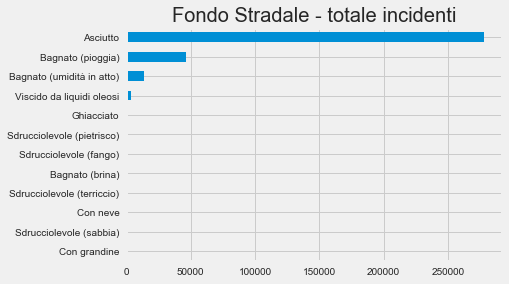

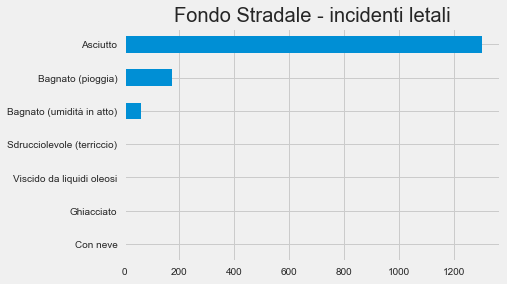

In [193]:
df.groupby(['FondoStradale'])\
  .count()[['ID']]\
  .sort_values(by='ID')\
  .plot(kind='barh')
plt.legend().set_visible(False)
plt.title('Fondo Stradale - totale incidenti')
plt.ylabel('')
plt.show()


df[df.NUM_MORTI>0].groupby(['FondoStradale'])\
                  .count()[['ID']]\
                  .sort_values(by='ID')\
                  .plot(kind='barh')
plt.legend().set_visible(False)
plt.title('Fondo Stradale - incidenti letali')
plt.ylabel('')
plt.show()

#  
#  
# Illuminazione + fondo stradale

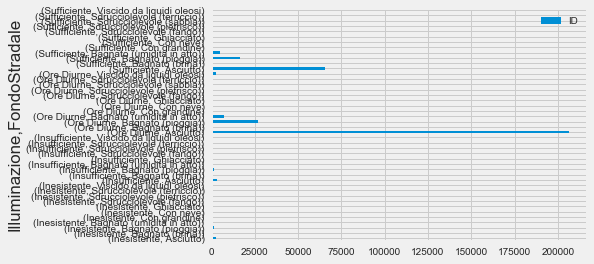

In [194]:
# df.groupby(['Illuminazione','FondoStradale']).count()[['ID']].plot(kind='barh')

In [195]:
df['FondoStradale'] = df['FondoStradale'].apply(lambda x: 'Sdrucciolevole' if 'Sdrucciolevole' in str(x) else x)
df['FondoStradale'] = df['FondoStradale'].apply(lambda x: 'Bagnato' if 'Bagnato' in str(x) else x)

In [203]:
# df[df['FondoStradale']=='Viscido da liquidi oleosi'].groupby('DataOraIncidente_date')\
#                                                     .count()[['ID']]\
#                                                     .plot(figsize=(10,5))

In [211]:
np.round(df.groupby(['Illuminazione','FondoStradale'])\
           .count()[['ID']]\
           .reset_index().pivot('Illuminazione','FondoStradale', 'ID')\
           .fillna(0)\
           .astype(int)/len(df)*100, 2)

FondoStradale,Asciutto,Bagnato,Con grandine,Con neve,Ghiacciato,Sdrucciolevole,Viscido da liquidi oleosi
Illuminazione,,,,,,,
Inesistente,0.84,0.52,0.0,0.00,0.01,0.01,0.01
Insufficiente,0.87,0.47,0.0,0.00,0.00,0.01,0.01
Ore Diurne,60.07,10.06,0.0,0.02,0.08,0.17,0.82
Sufficiente,19.14,6.25,0.0,0.01,0.02,0.05,0.19


In [209]:
np.round(df[df.NUM_MORTI>0].groupby(['Illuminazione','FondoStradale'])\
                  .count()[['ID']]\
                  .reset_index().pivot('Illuminazione','FondoStradale', 'ID')\
                  .fillna(0)\
                  .astype(int)/len(df[df.NUM_MORTI>0])*100, 2)

FondoStradale,Asciutto,Bagnato,Con neve,Ghiacciato,Sdrucciolevole,Viscido da liquidi oleosi
Illuminazione,,,,,,
Inesistente,4.59,1.23,0.00,0.06,0.00,0.00
Insufficiente,3.49,1.03,0.00,0.00,0.00,0.00
Ore Diurne,48.38,5.24,0.00,0.00,0.00,0.00
Sufficiente,27.75,7.57,0.06,0.00,0.13,0.06


In [200]:
# plt.figure(figsize=(10,10))
# sns.heatmap(
#     df.groupby(['Illuminazione','FondoStradale'])\
#     .count()[['ID']]\
#     .reset_index().pivot('Illuminazione','FondoStradale', 'ID'),
#     annot=True
# )

#  
#  
#  Segnaletica

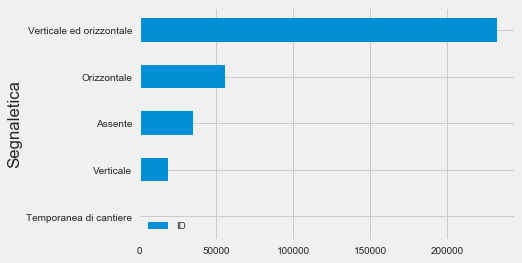

In [212]:
df.groupby('Segnaletica').count()[['ID']].sort_values(by='ID').plot(kind='barh')

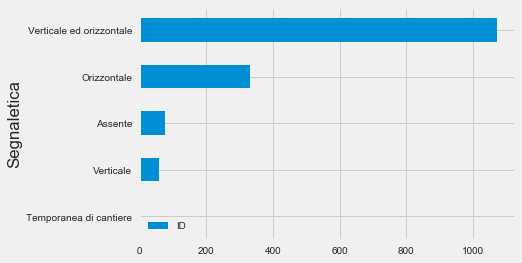

In [213]:
df[df['NUM_MORTI']>0].groupby('Segnaletica').count()[['ID']].sort_values(by='ID').plot(kind='barh')

#  
#  
#  Pavimentazione

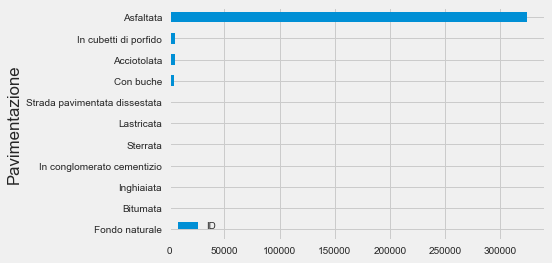

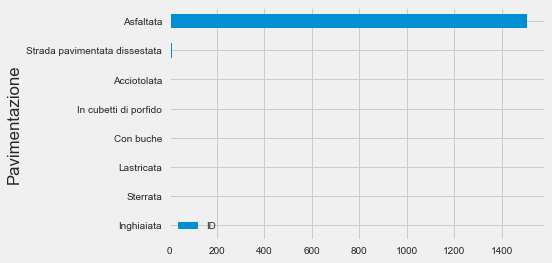

In [215]:
df.groupby('Pavimentazione').count()[['ID']].sort_values(by='ID').plot(kind='barh')

df[df.NUM_MORTI>0].groupby('Pavimentazione').count()[['ID']].sort_values(by='ID').plot(kind='barh')

#  
#  
#  Particolarita Strade

In [221]:
len(df)

344040

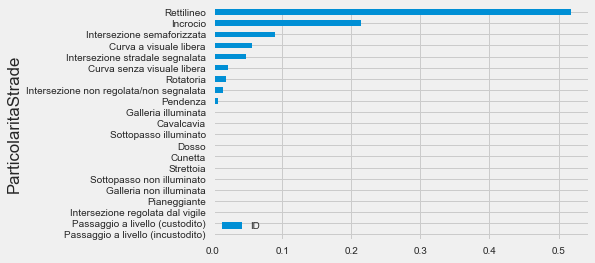

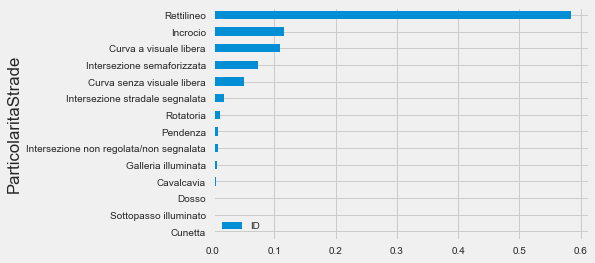

In [228]:
(df.groupby('ParticolaritaStrade')\
  .count()[['ID']]\
  .sort_values(by='ID')/len(df))\
  .plot(kind='barh')
    
    
    
(df[df.NUM_MORTI>0].groupby('ParticolaritaStrade')\
  .count()[['ID']]\
  .sort_values(by='ID')/len(df[df.NUM_MORTI>0]))\
  .plot(kind='barh')
#df[df.NUM_MORTI>0].groupby('ParticolaritaStrade').count()[['ID']].sort_values(by='ID').plot(kind='barh')

#  
#  
#  Traffico

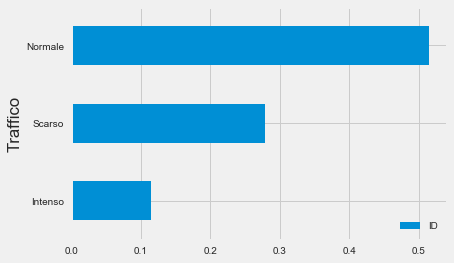

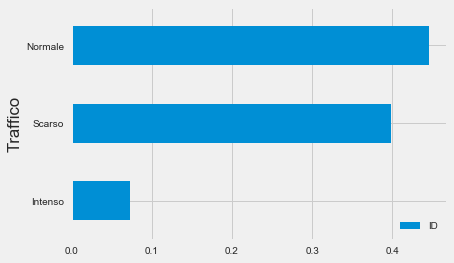

In [229]:
(df.groupby('Traffico')\
  .count()[['ID']]\
  .sort_values(by='ID')/len(df))\
  .plot(kind='barh')
    
    
    
(df[df.NUM_MORTI>0].groupby('Traffico')\
  .count()[['ID']]\
  .sort_values(by='ID')/len(df[df.NUM_MORTI>0]))\
  .plot(kind='barh')
#df[df.NUM_MORTI>0].groupby('ParticolaritaStrade').count()[['ID']].sort_values(by='ID').plot(kind='barh')

#  
#  
#  Localizzazione1 (aka Tipo di strada)

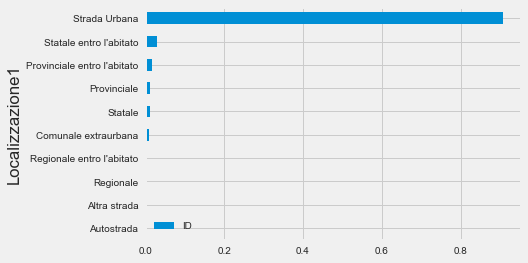

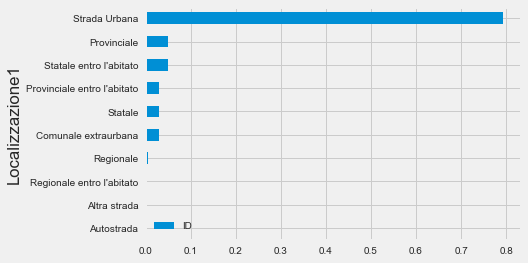

In [231]:
(df.groupby('Localizzazione1')\
  .count()[['ID']]\
  .sort_values(by='ID')/len(df))\
  .plot(kind='barh')
      
(df[df.NUM_MORTI>0].groupby('Localizzazione1')\
  .count()[['ID']]\
  .sort_values(by='ID')/len(df[df.NUM_MORTI>0]))\
  .plot(kind='barh')

#  
#  
#  TipoStrada

(0, 1)

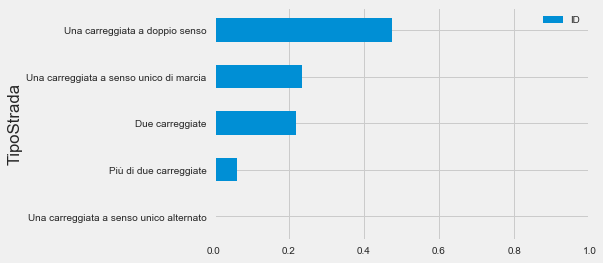

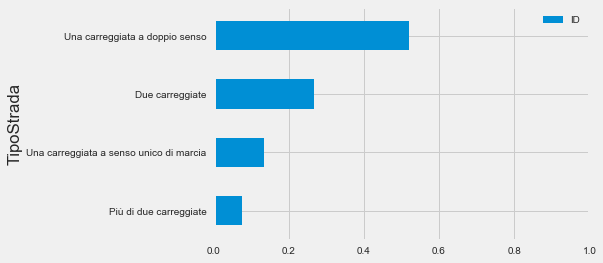

In [239]:
(df.groupby('TipoStrada')\
  .count()[['ID']]\
  .sort_values(by='ID')/len(df))\
  .plot(kind='barh')
plt.xlim(0,1)
      
(df[df.NUM_MORTI>0].groupby('TipoStrada')\
  .count()[['ID']]\
  .sort_values(by='ID')/len(df[df.NUM_MORTI>0]))\
  .plot(kind='barh')
plt.xlim(0,1)

#  
#  
# Gruppo e Confermato

In [234]:
df.groupby('Confermato').count()[['ID']]

,ID
Confermato,
0.0,4130
1.0,309115


In [235]:
df.groupby('Gruppo').count()[['ID']]

,ID
Gruppo,
1,33125
2,19329
3,9649
4,19340
5,16210
6,12368
7,15125
8,26718
9,14270
